In [1]:
import numpy as np
import pandas as pd
import pandas as pd
import numpy as np
import nltk as n
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import re
from nltk.corpus import stopwords, wordnet
from transformers import pipeline
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, adjusted_rand_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

2022-12-15 21:31:28.979012: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# combine data with sentiment
data = pd.read_csv('data_byuser.csv')
sent = pd.read_csv('sent.csv')
sent = sent[['#AUTHID', 'sentiment']]
df = pd.merge(data, sent, on='#AUTHID')
df = df.drop('Unnamed: 0', axis=1)
df.to_csv('data_cansu.csv')

In [18]:
data_cecilia = pd.read_csv('cecilia_data.csv')
data_cecilia.columns

In [20]:
data_cecilia['#AUTHID'] = data_cecilia['ID']
data_cecilia = data_cecilia[['#AUTHID', 'anger', 'anticipation', 'disgust', 'fear', 'joy',
       'negative', 'positive', 'sadness', 'surprise', 'trust']]

In [32]:
final_data = pd.merge(df, data_cecilia, on = ['#AUTHID'])

In [35]:
final_data = final_data[['#AUTHID', 'STATUS', 'status_words', 'NETWORKSIZE',
       'BETWEENNESS', 'NBETWEENNESS', 'DENSITY', 'BROKERAGE', 'NBROKERAGE',
       'TRANSITIVITY', 'post_count', 'total_words',
       'avg_words', 'me_words', 'me_perpost', 'sentiment', 'anger',
       'anticipation', 'disgust', 'fear', 'joy', 'negative', 'positive',
       'sadness', 'surprise', 'trust', 'cEXT', 'cNEU', 'cAGR', 'cCON', 'cOPN']]

In [39]:
# This is the final dataset for analysis
final_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 239 entries, 0 to 238
Data columns (total 31 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   #AUTHID       239 non-null    int64  
 1   STATUS        239 non-null    object 
 2   status_words  239 non-null    object 
 3   NETWORKSIZE   239 non-null    float64
 4   BETWEENNESS   239 non-null    float64
 5   NBETWEENNESS  239 non-null    float64
 6   DENSITY       239 non-null    float64
 7   BROKERAGE     239 non-null    float64
 8   NBROKERAGE    239 non-null    float64
 9   TRANSITIVITY  239 non-null    float64
 10  post_count    239 non-null    int64  
 11  total_words   239 non-null    int64  
 12  avg_words     239 non-null    float64
 13  me_words      239 non-null    int64  
 14  me_perpost    239 non-null    float64
 15  sentiment     239 non-null    float64
 16  anger         239 non-null    int64  
 17  anticipation  239 non-null    int64  
 18  disgust       239 non-null    

In [40]:
final_data.to_csv('final_data.csv')

In [81]:
final_data = pd.read_csv('final_data.csv')

## Model

### Splitting test/train

In [61]:
final_data = pd.read_csv('data_cansu.csv')
final_data = final_data[['#AUTHID','NETWORKSIZE','NBETWEENNESS', 'DENSITY','NBROKERAGE', 'TRANSITIVITY','avg_words', 'me_perpost', 'sentiment', 'cEXT', 'cNEU', 'cAGR', 'cCON', 'cOPN']]

In [3]:
scaler = MinMaxScaler()
final_data['scaled_ntwksz'] = scaler.fit_transform(final_data['NETWORKSIZE'].values.reshape(-1,1))

In [82]:
final_data = final_data.drop(['Unnamed: 0', 'STATUS', 'status_words'], axis = 1)
final_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 239 entries, 0 to 238
Data columns (total 29 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   #AUTHID       239 non-null    int64  
 1   NETWORKSIZE   239 non-null    float64
 2   BETWEENNESS   239 non-null    float64
 3   NBETWEENNESS  239 non-null    float64
 4   DENSITY       239 non-null    float64
 5   BROKERAGE     239 non-null    float64
 6   NBROKERAGE    239 non-null    float64
 7   TRANSITIVITY  239 non-null    float64
 8   post_count    239 non-null    int64  
 9   total_words   239 non-null    int64  
 10  avg_words     239 non-null    float64
 11  me_words      239 non-null    int64  
 12  me_perpost    239 non-null    float64
 13  sentiment     239 non-null    float64
 14  anger         239 non-null    int64  
 15  anticipation  239 non-null    int64  
 16  disgust       239 non-null    int64  
 17  fear          239 non-null    int64  
 18  joy           239 non-null    

In [83]:
# Splitting test/train
final_data = final_data.sort_values(by = '#AUTHID').reset_index(drop=True) #just in case

train_df, test_df = train_test_split(final_data, test_size = 0.2, random_state = 9)
train_df = train_df.sort_values(by = '#AUTHID').reset_index(drop=True)
test_df = test_df.sort_values(by = '#AUTHID').reset_index(drop=True)

print(f"No. of training examples: {train_df.shape[0]}")
print(f"No. of testing examples: {test_df.shape[0]}")

No. of training examples: 191
No. of testing examples: 48


In [84]:
big5 = ['cEXT', 'cNEU', 'cAGR', 'cCON', 'cOPN']

x_train, y_train = train_df.drop(big5, axis=1), train_df[big5]

In [80]:
x_train.drop('NETWORKSIZE', axis = 1)

,#AUTHID,BETWEENNESS,NBETWEENNESS,DENSITY,BROKERAGE,NBROKERAGE,TRANSITIVITY,post_count,total_words,avg_words,...,anger,anticipation,disgust,fear,joy,negative,positive,sadness,surprise,trust
0,2,8096.60,92.24,0.07,8311.0,0.47,0.35,6,39,6.500000,...,0,0,0,1,1,1,1,0,1,0
1,3,164031.00,96.69,0.02,167499.0,0.49,0.12,5,137,27.400000,...,4,6,4,1,6,4,7,3,4,6
2,4,21894.70,90.06,0.04,23462.0,0.48,0.21,8,166,20.750000,...,4,2,4,4,6,9,12,5,3,3
3,6,25651.90,93.30,0.03,26805.0,0.49,0.18,14,261,18.642857,...,3,4,1,3,4,3,5,3,0,2
4,7,91298.50,98.98,0.01,91701.0,0.50,0.03,172,2320,13.488372,...,13,63,13,28,58,48,105,26,27,50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
186,246,48253.60,99.46,0.01,48356.0,0.50,0.01,6,26,4.333333,...,0,0,0,1,1,0,1,0,1,0
187,247,22856.80,86.79,0.06,24946.0,0.47,0.36,3,47,15.666667,...,1,2,1,4,2,4,3,2,0,2
188,248,24340.70,74.57,0.05,31404.0,0.48,0.16,30,502,16.733333,...,4,14,3,9,28,16,43,11,3,17
189,249,4143.03,94.78,0.05,4239.0,0.48,0.16,19,216,11.368421,...,4,9,4,2,9,11,14,5,6,8


### Finding Elbow for KMeans

In [85]:
# elbow
kmeans_kwargs = {
    "init": "random",
    "n_init": 10,
    "max_iter": 300,
    "random_state": 123,
}

# A list holds the SSE values for each k
sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(x_train)
    sse.append(kmeans.inertia_)

In [86]:
from kneed import KneeLocator
kl = KneeLocator(
    range(1, 11), sse, curve="convex", direction="decreasing"
)

kl.elbow

3

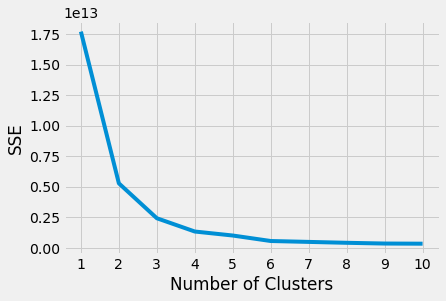

In [87]:
plt.style.use("fivethirtyeight")
plt.plot(range(1, 11), sse)
plt.xticks(range(1, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

In [88]:
# A list holds the silhouette coefficients for each k
silhouette_coefficients = []

# Notice you start at 2 clusters for silhouette coefficient
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(x_train)
    score = silhouette_score(x_train, kmeans.labels_)
    silhouette_coefficients.append(score)

In [89]:
silhouette_coefficients

[0.7871650851322363,
 0.7267839580334924,
 0.7008722105877768,
 0.6360903732820482,
 0.6250746064416172,
 0.5929015075869639,
 0.6068947888616112,
 0.6128983229033228,
 0.590508964134606]

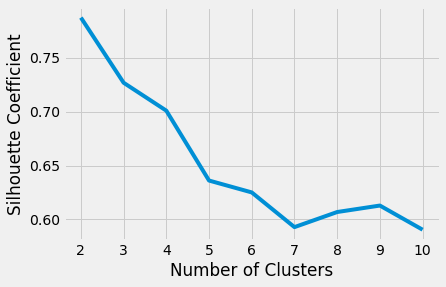

In [90]:
plt.style.use("fivethirtyeight")
plt.plot(range(2, 11), silhouette_coefficients)
plt.xticks(range(2, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Coefficient")
plt.show()

In [91]:
kmeans = KMeans(
    init="random",
    n_clusters=3,
    n_init=10,
    max_iter=300,
    random_state=42
)

kmeans.fit(x_train)

KMeans(init='random', n_clusters=3, random_state=42)

In [92]:
# The lowest SSE value
kmeans.inertia_

# Final locations of the centroid
kmeans.cluster_centers_

# The number of iterations required to converge
kmeans.n_iter_

10

In [93]:
kmeans.labels_

array([2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       0, 2, 2, 2, 1, 2, 2, 2, 2, 2, 1, 2, 1, 2, 2, 2, 0, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 0, 2, 1, 1, 2, 2, 1, 1, 2, 2, 1, 2, 1, 1, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 1, 1, 2, 2, 2, 2, 2, 0, 2, 2, 0, 1, 2, 2, 2,
       2, 2, 2, 0, 1, 2, 2, 2, 1, 2, 2, 2, 2, 1, 2, 0, 2, 2, 2, 2, 1, 1,
       2, 2, 2, 2, 1, 2, 2, 2, 0, 1, 2, 2, 2, 1, 2, 2, 1, 2, 2, 0, 2, 2,
       2, 2, 2, 1, 2, 2, 2, 2, 2, 0, 2, 1, 2, 0, 2, 2, 2, 2, 2, 2, 1, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 1, 1, 2, 1, 2, 2, 2, 2, 1,
       1, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], dtype=int32)

In [94]:
y_train['first_labels'] = kmeans.labels_

/var/folders/qk/0w6s_3jd78s0prl6n7n20kd00000gn/T/ipykernel_15870/3902523292.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_train['first_labels'] = kmeans.labels_


In [95]:
y_0 = y_train[y_train['first_labels'] == 0]
y_1 = y_train[y_train['first_labels'] == 1]
y_2 = y_train[y_train['first_labels'] == 2]

In [96]:
# y_0
print('There are ', len(y_0), 'total users in y_0. ', 
      sum(y_0['cEXT']), ' are extroverted, ',
      sum(y_0['cNEU']), ' are neurotic, ',
      sum(y_0['cAGR']), ' are agreeable',
      sum(y_0['cCON']), ' are concientious',
      sum(y_0['cOPN']), ' are open')

There are  12 total users in y_0.  8  are extroverted,  4  are neurotic,  8  are agreeable 8  are concientious 9  are open


In [97]:
# y_1
print('There are ', len(y_1), 'total users in y_1. ', 
      sum(y_1['cEXT']), ' are extroverted, ',
      sum(y_1['cNEU']), ' are neurotic, ',
      sum(y_1['cAGR']), ' are agreeable',
      sum(y_1['cCON']), ' are concientious',
      sum(y_1['cOPN']), ' are open')

There are  34 total users in y_1.  21  are extroverted,  10  are neurotic,  18  are agreeable 21  are concientious 23  are open


In [98]:
# y_2
print('There are ', len(y_2), 'total users in y_2. ', 
      sum(y_2['cEXT']), ' are extroverted, ',
      sum(y_2['cNEU']), ' are neurotic, ',
      sum(y_2['cAGR']), ' are agreeable',
      sum(y_2['cCON']), ' are concientious',
      sum(y_2['cOPN']), ' are open')

There are  145 total users in y_2.  40  are extroverted,  59  are neurotic,  75  are agreeable 70  are concientious 107  are open


In [100]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 191 entries, 0 to 190
Data columns (total 29 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   #AUTHID       191 non-null    int64  
 1   NETWORKSIZE   191 non-null    float64
 2   BETWEENNESS   191 non-null    float64
 3   NBETWEENNESS  191 non-null    float64
 4   DENSITY       191 non-null    float64
 5   BROKERAGE     191 non-null    float64
 6   NBROKERAGE    191 non-null    float64
 7   TRANSITIVITY  191 non-null    float64
 8   post_count    191 non-null    int64  
 9   total_words   191 non-null    int64  
 10  avg_words     191 non-null    float64
 11  me_words      191 non-null    int64  
 12  me_perpost    191 non-null    float64
 13  sentiment     191 non-null    float64
 14  anger         191 non-null    int64  
 15  anticipation  191 non-null    int64  
 16  disgust       191 non-null    int64  
 17  fear          191 non-null    int64  
 18  joy           191 non-null    

### Creating KMeans Pipeline

In [26]:
preprocessor = Pipeline([
        ("scaler", MinMaxScaler()),
        ("pca", PCA(n_components=2, random_state=123))])

In [45]:
n_clusters = 4
clusterer = Pipeline([
       (
           "kmeans",
           KMeans(
               n_clusters=n_clusters,
               init="k-means++",
               n_init=50,
               max_iter=500,
               random_state=123,
           ),
       ),
])

In [46]:
pipe = Pipeline([("preprocessor", preprocessor), ("clusterer", clusterer)])

In [47]:
pipe.fit(x_train)

Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('scaler', MinMaxScaler()),
                                 ('pca',
                                  PCA(n_components=2, random_state=123))])),
                ('clusterer',
                 Pipeline(steps=[('kmeans',
                                  KMeans(max_iter=500, n_clusters=4, n_init=50,
                                         random_state=123))]))])

In [48]:
preprocessed_data = pipe["preprocessor"].transform(x_train)

predicted_labels = pipe["clusterer"]["kmeans"].labels_

silhouette_score(preprocessed_data, predicted_labels)

0.3644466898194655

In [49]:
pcadf = pd.DataFrame(
    pipe["preprocessor"].transform(x_train),
    columns=["component_1", "component_2"],
)

pcadf["predicted_cluster"] = pipe["clusterer"]["kmeans"].labels_
#pcadf["true_label"] = label_encoder.inverse_transform(true_labels)

/Users/cansufreeman/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


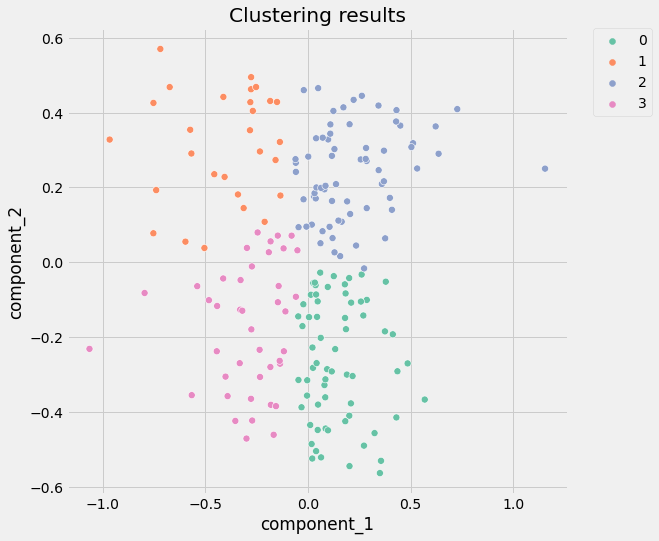

In [50]:
plt.style.use("fivethirtyeight")
plt.figure(figsize=(8, 8))

scat = sns.scatterplot(
    "component_1",
    "component_2",
    s=50,
    data=pcadf,
    hue="predicted_cluster",
    #style="true_label",
    palette="Set2",
)

scat.set_title(
    "Clustering results"
)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)

plt.show()

In [51]:
def kmeans_pipline(x_train, n):
    preprocessor = Pipeline([("scaler", 
                              MinMaxScaler()),
                             ("pca", PCA(n_components=2,random_state=123))])
    
    n_clusters = n
    clusterer = Pipeline([("kmeans",
                           KMeans(n_clusters=n_clusters, 
                                  init="k-means++",
                                  n_init=50,
                                  max_iter=500,
                                  random_state=123)
                          )
                         ])
    
    pipe = Pipeline([("preprocessor", preprocessor), ("clusterer", clusterer)])
    
    pipe.fit(x_train)
    
    preprocessed_data = pipe["preprocessor"].transform(x_train)
    predicted_labels = pipe["clusterer"]["kmeans"].labels_
    print(silhouette_score(preprocessed_data, predicted_labels))
    
    
    pcadf = pd.DataFrame(pipe["preprocessor"].transform(x_train),
                         columns=["component_1", "component_2"])

    pcadf["predicted_cluster"] = pipe["clusterer"]["kmeans"].labels_
    
    return pcadf

def pca_cluster_plot(df):
    
    plt.style.use("fivethirtyeight")
    plt.figure(figsize=(8, 8))

    scat = sns.scatterplot("component_1", "component_2", s=50, 
                           data=df, hue="predicted_cluster", palette="Set2",)

    scat.set_title("Clustering results")
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)
    plt.show()
   
    

In [55]:
kmeans_pipline(x_train,2)

0.34127101236606505


,component_1,component_2,predicted_cluster
0,0.202730,-0.545071,0
1,0.350757,-0.563756,0
2,-0.299074,-0.471400,0
3,0.021279,-0.524809,0
4,0.064231,-0.521758,0
...,...,...,...
195,0.050098,0.465630,1
196,0.431549,0.406790,1
197,0.262826,0.445227,1
198,0.343898,0.419102,1


0.4274891650764123


/Users/cansufreeman/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


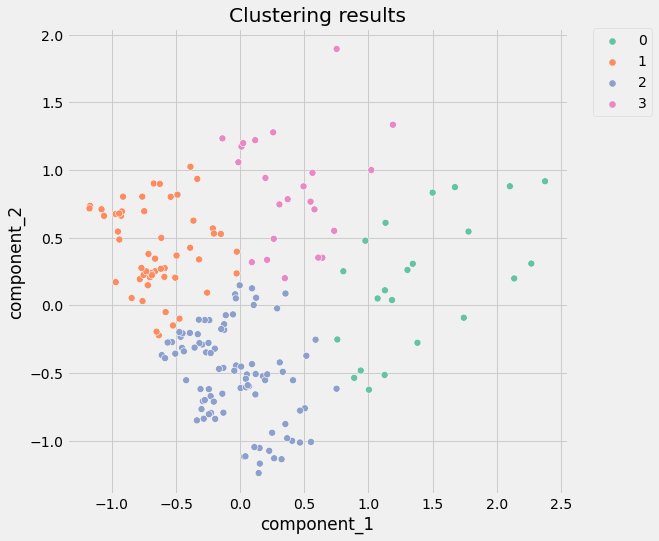

In [129]:
pca_cluster_plot(kmeans_pipline(train_df,4))

In [42]:
data_ext = x_train[['me_perpost', 'anger',
       'anticipation', 'disgust', 'fear', 'joy', 'negative','sadness', 'surprise', 'trust']]

In [112]:
ext = kmeans_pipline(data_ext,4)

0.5384347466412976


/Users/cansufreeman/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


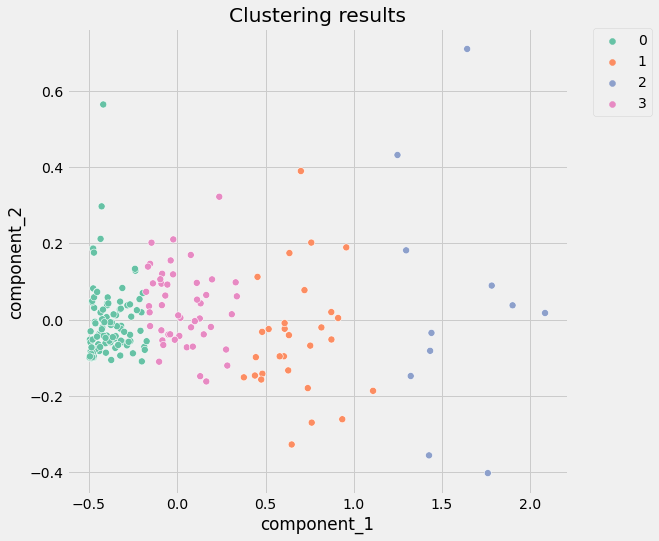

In [113]:
pca_cluster_plot(ext)

In [45]:
ext

,component_1,component_2,predicted_cluster
0,-0.483504,-0.097493,0
1,-0.338534,-0.018094,0
2,-0.317637,-0.015842,0
3,-0.400031,0.006867,0
4,0.635452,0.174914,1
...,...,...,...
183,0.112248,0.052773,0
184,-0.485608,-0.072548,0
185,-0.420508,0.026560,0
186,-0.137595,0.095376,0


In [46]:
cb = y_train.join(ext)

In [47]:
cb

,cEXT,cNEU,cAGR,cCON,cOPN,component_1,component_2,predicted_cluster
0,0,1,0,0,0,-0.483504,-0.097493,0
1,1,1,0,1,0,-0.338534,-0.018094,0
2,0,1,1,1,1,-0.317637,-0.015842,0
3,0,1,0,1,1,-0.400031,0.006867,0
4,0,0,1,0,1,0.635452,0.174914,1
...,...,...,...,...,...,...,...,...
183,0,1,1,1,1,0.112248,0.052773,0
184,0,0,1,0,0,-0.485608,-0.072548,0
185,0,0,0,1,1,-0.420508,0.026560,0
186,0,0,1,0,1,-0.137595,0.095376,0


In [64]:
#cb[cb['predicted_cluster'] == 1][['cOPN', 'cAGR']]

In [58]:
sum(cb[cb['predicted_cluster'] == 0]['cOPN'])

104

In [61]:
sum(cb[cb['predicted_cluster'] == 0]['cAGR'])

80

In [65]:
x = x_train.join(cb)

In [67]:
x.describe()

,#AUTHID,NETWORKSIZE,BETWEENNESS,NBETWEENNESS,DENSITY,BROKERAGE,NBROKERAGE,TRANSITIVITY,post_count,total_words,...,surprise,trust,cEXT,cNEU,cAGR,cCON,cOPN,component_1,component_2,predicted_cluster
count,188.000000,188.000000,1.880000e+02,188.000000,188.000000,1.880000e+02,188.000000,188.000000,188.000000,188.000000,...,188.000000,188.000000,188.000000,188.000000,188.000000,188.000000,188.000000,1.880000e+02,1.880000e+02,188.000000
mean,125.643617,426.819149,1.391733e+05,94.291809,0.031330,1.417804e+05,0.489468,0.131809,43.196809,642.372340,...,10.329787,18.867021,0.367021,0.382979,0.537234,0.515957,0.728723,5.905442e-19,-1.062979e-17,0.223404
std,71.171974,325.190490,2.158278e+05,6.086079,0.027824,2.183295e+05,0.011734,0.108568,45.469019,721.637776,...,12.523252,22.966341,0.483279,0.487411,0.499943,0.501080,0.445806,5.602603e-01,1.312539e-01,0.417639
min,2.000000,29.000000,3.344200e+02,61.250000,0.000000,3.480000e+02,0.430000,0.000000,1.000000,6.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-4.970450e-01,-4.022595e-01,0.000000
25%,66.750000,187.750000,1.631593e+04,93.467500,0.010000,1.709550e+04,0.490000,0.057500,9.000000,109.500000,...,2.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-4.080678e-01,-7.075287e-02,0.000000
50%,125.500000,323.500000,4.962455e+04,96.215000,0.020000,5.100000e+04,0.490000,0.100000,27.000000,357.500000,...,5.000000,10.000000,0.000000,0.000000,1.000000,1.000000,1.000000,-2.053607e-01,-2.013063e-02,0.000000
75%,186.250000,563.500000,1.538512e+05,97.950000,0.040000,1.564638e+05,0.500000,0.172500,65.750000,918.500000,...,14.250000,28.250000,1.000000,1.000000,1.000000,1.000000,1.000000,1.923493e-01,5.022588e-02,0.000000
max,250.000000,1596.000000,1.251780e+06,99.670000,0.150000,1.263790e+06,0.500000,0.520000,223.000000,3572.000000,...,76.000000,154.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.083376e+00,7.103282e-01,1.000000


In [116]:
ext = kmeans_pipline(df,4)

0.40323092721559584


/Users/cansufreeman/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


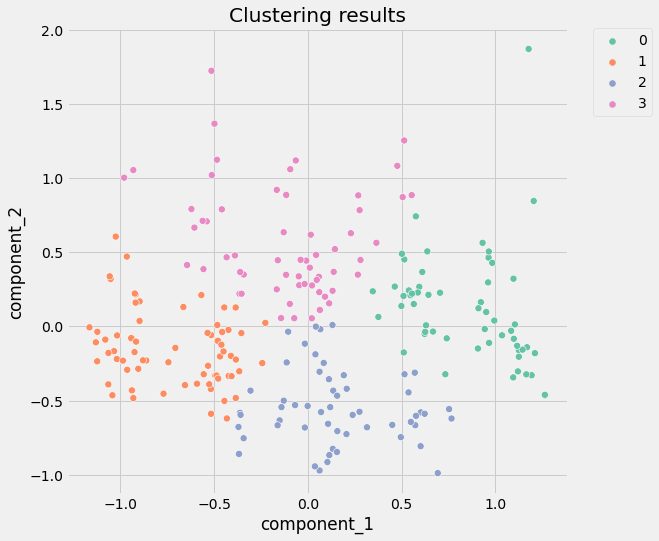

In [117]:
pca_cluster_plot(ext)

In [118]:
ext

,component_1,component_2,predicted_cluster
0,1.264649,-0.464847,0
1,0.132911,-0.825377,2
2,0.191317,-0.328855,2
3,0.114301,-0.867141,2
4,0.572719,-0.665837,2
...,...,...,...
234,0.042465,-0.001015,2
235,0.107633,-0.656406,2
236,0.043669,0.482115,3
237,0.154878,-0.846071,2


In [119]:
x = df.join(ext)

In [120]:
x0 = x[x['predicted_cluster'] == 0]
x1 = x[x['predicted_cluster'] == 1]
x2 = x[x['predicted_cluster'] == 2]
x3 = x[x['predicted_cluster'] == 3]

In [121]:
x0[x0['cNEU'] == 0]

,#AUTHID,NETWORKSIZE,BETWEENNESS,NBETWEENNESS,DENSITY,BROKERAGE,NBROKERAGE,TRANSITIVITY,post_count,total_words,...,surprise,trust,cEXT,cNEU,cAGR,cCON,cOPN,component_1,component_2,predicted_cluster
79,84,222.0,17150.1,70.55,0.09,22359.0,0.46,0.34,22,251,...,2,4,0,0,0,0,1,0.622723,-0.050443,0
121,127,562.0,146858.0,93.49,0.02,155268.0,0.49,0.06,57,1018,...,12,22,0,0,0,0,1,0.346009,0.236827,0
126,132,216.0,19345.4,84.09,0.06,21766.0,0.47,0.33,30,593,...,6,11,0,0,0,0,1,0.564610,0.150938,0
206,216,322.0,47166.9,91.84,0.02,50780.0,0.49,0.04,75,1500,...,24,37,0,0,0,0,0,0.509961,0.205792,0
238,250,144.0,6219.2,61.25,0.15,8791.0,0.43,0.48,21,192,...,3,4,0,0,0,0,1,0.740443,-0.080290,0


In [122]:
x0.describe()

,#AUTHID,NETWORKSIZE,BETWEENNESS,NBETWEENNESS,DENSITY,BROKERAGE,NBROKERAGE,TRANSITIVITY,post_count,total_words,...,surprise,trust,cEXT,cNEU,cAGR,cCON,cOPN,component_1,component_2,predicted_cluster
count,56.000000,56.000000,5.600000e+01,56.000000,56.000000,5.600000e+01,56.000000,56.000000,56.000000,56.000000,...,56.000000,56.000000,56.000000,56.000000,56.000000,56.000000,56.000000,56.000000,56.000000,56.0
mean,126.178571,284.785714,7.188717e+04,92.108929,0.045536,7.367477e+04,0.484286,0.176071,39.357143,618.625000,...,9.589286,17.000000,0.053571,0.910714,0.250000,0.035714,0.678571,0.847907,0.118366,0.0
std,66.644268,264.717943,1.804496e+05,6.802764,0.031961,1.823212e+05,0.013329,0.123313,44.769888,848.494036,...,14.821087,23.995454,0.227208,0.287736,0.436931,0.187256,0.471251,0.270658,0.377226,0.0
min,2.000000,24.000000,2.250000e+02,61.250000,0.000000,2.410000e+02,0.430000,0.000000,1.000000,6.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.346009,-0.464847,0.0
25%,83.500000,132.000000,7.415200e+03,90.607500,0.020000,8.165500e+03,0.480000,0.067500,9.000000,86.250000,...,1.000000,2.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.592270,-0.132893,0.0
50%,126.000000,219.000000,1.996380e+04,93.480000,0.040000,2.206250e+04,0.490000,0.140000,25.000000,325.500000,...,4.000000,8.500000,0.000000,1.000000,0.000000,0.000000,1.000000,0.927087,0.080560,0.0
75%,170.500000,355.750000,5.899283e+04,96.322500,0.060000,6.181300e+04,0.490000,0.272500,53.000000,911.750000,...,13.000000,23.250000,0.000000,1.000000,0.250000,0.000000,1.000000,1.099683,0.267556,0.0
max,250.000000,1560.000000,1.200910e+06,99.490000,0.150000,1.213740e+06,0.500000,0.480000,223.000000,5341.000000,...,95.000000,137.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.264649,1.870709,0.0


In [123]:
x1.describe()

,#AUTHID,NETWORKSIZE,BETWEENNESS,NBETWEENNESS,DENSITY,BROKERAGE,NBROKERAGE,TRANSITIVITY,post_count,total_words,...,surprise,trust,cEXT,cNEU,cAGR,cCON,cOPN,component_1,component_2,predicted_cluster
count,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000,69.00000,...,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000,69.0
mean,129.376812,540.463768,205457.063478,96.256957,0.020725,208800.724638,0.493768,0.094493,34.275362,469.42029,...,7.666667,13.782609,0.666667,0.043478,0.840580,0.971014,0.869565,-0.712554,-0.147235,1.0
std,65.927791,363.394963,244942.218948,3.842895,0.017348,248190.579714,0.006882,0.066654,30.686213,468.91525,...,7.709175,13.739027,0.474858,0.205425,0.368749,0.168995,0.339248,0.272690,0.246718,0.0
min,8.000000,46.000000,967.500000,73.160000,0.000000,976.000000,0.460000,0.000000,2.000000,9.00000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.164595,-0.620261,1.0
25%,74.000000,278.000000,36015.400000,95.260000,0.010000,36920.000000,0.490000,0.050000,8.000000,98.00000,...,2.000000,3.000000,0.000000,0.000000,1.000000,1.000000,1.000000,-0.942178,-0.330723,1.0
50%,136.000000,419.000000,82803.900000,97.200000,0.020000,85492.000000,0.490000,0.080000,27.000000,371.00000,...,6.000000,10.000000,1.000000,0.000000,1.000000,1.000000,1.000000,-0.663873,-0.172769,1.0
75%,187.000000,804.000000,312739.000000,98.270000,0.030000,321175.000000,0.500000,0.130000,44.000000,596.00000,...,11.000000,20.000000,1.000000,0.000000,1.000000,1.000000,1.000000,-0.468444,-0.036037,1.0
max,238.000000,1350.000000,895790.000000,99.820000,0.120000,904309.000000,0.500000,0.310000,126.000000,1911.00000,...,39.000000,66.000000,1.000000,1.000000,1.000000,1.000000,1.000000,-0.226833,0.605843,1.0


In [124]:
x2.describe()

,#AUTHID,NETWORKSIZE,BETWEENNESS,NBETWEENNESS,DENSITY,BROKERAGE,NBROKERAGE,TRANSITIVITY,post_count,total_words,...,surprise,trust,cEXT,cNEU,cAGR,cCON,cOPN,component_1,component_2,predicted_cluster
count,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,...,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.0
mean,105.872727,359.018182,89699.228909,93.707818,0.035455,91588.254545,0.486182,0.169818,26.218182,316.781818,...,4.327273,8.818182,0.236364,0.490909,0.254545,0.890909,0.490909,0.156719,-0.547497,2.0
std,80.563767,242.415124,123352.268443,4.903254,0.025879,124864.812914,0.010970,0.116532,27.477729,350.201883,...,4.799902,9.843386,0.428764,0.504525,0.439620,0.314627,0.504525,0.307676,0.248701,0.0
min,3.000000,72.000000,2015.240000,80.950000,0.000000,2262.000000,0.460000,0.010000,1.000000,13.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.370063,-0.988644,2.0
25%,31.500000,173.500000,13722.550000,91.715000,0.020000,14322.000000,0.480000,0.085000,8.000000,83.500000,...,1.000000,2.500000,0.000000,0.000000,0.000000,1.000000,0.000000,-0.016074,-0.680601,2.0
50%,101.000000,298.000000,41492.800000,94.920000,0.030000,42968.000000,0.490000,0.140000,15.000000,194.000000,...,3.000000,6.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.114301,-0.582257,2.0
75%,175.500000,495.000000,116183.000000,97.280000,0.050000,119813.500000,0.490000,0.220000,36.000000,392.000000,...,5.500000,11.000000,0.000000,1.000000,0.500000,1.000000,1.000000,0.382661,-0.426406,2.0
max,249.000000,1118.000000,614830.000000,99.460000,0.120000,622150.000000,0.500000,0.460000,99.000000,1556.000000,...,21.000000,38.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.766042,0.009666,2.0


In [125]:
x3.describe()

,#AUTHID,NETWORKSIZE,BETWEENNESS,NBETWEENNESS,DENSITY,BROKERAGE,NBROKERAGE,TRANSITIVITY,post_count,total_words,...,surprise,trust,cEXT,cNEU,cAGR,cCON,cOPN,component_1,component_2,predicted_cluster
count,59.000000,59.000000,5.900000e+01,59.000000,59.000000,5.900000e+01,59.000000,59.000000,59.000000,59.000000,...,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000,59.0
mean,137.169492,447.067797,1.468086e+05,94.830169,0.027966,1.493233e+05,0.491864,0.106780,65.898305,1087.593220,...,17.915254,32.152542,0.508475,0.169492,0.762712,0.101695,0.796610,-0.117560,0.570221,3.0
std,72.774132,323.336691,2.255780e+05,6.924711,0.027529,2.271053e+05,0.010744,0.100489,57.051911,919.074443,...,16.580304,30.228334,0.504219,0.378406,0.429072,0.304841,0.405975,0.346643,0.366099,0.0
min,7.000000,29.000000,3.344200e+02,66.080000,0.000000,3.480000e+02,0.450000,0.010000,2.000000,24.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.979729,0.055085,3.0
25%,72.500000,253.500000,2.750065e+04,95.520000,0.010000,3.049550e+04,0.490000,0.040000,17.000000,287.500000,...,5.000000,10.500000,0.000000,0.000000,1.000000,0.000000,1.000000,-0.376770,0.299925,3.0
50%,141.000000,367.000000,5.651590e+04,97.050000,0.020000,6.294000e+04,0.490000,0.080000,48.000000,845.000000,...,13.000000,23.000000,1.000000,0.000000,1.000000,0.000000,1.000000,-0.064589,0.449230,3.0
75%,200.500000,636.000000,1.981070e+05,98.385000,0.030000,1.998435e+05,0.500000,0.150000,103.000000,1716.000000,...,26.500000,46.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.077562,0.831704,3.0
max,248.000000,1596.000000,1.251780e+06,99.670000,0.140000,1.263790e+06,0.500000,0.520000,219.000000,3572.000000,...,76.000000,154.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.553666,1.723666,3.0


In [127]:
df.columns

Index(['#AUTHID', 'NETWORKSIZE', 'BETWEENNESS', 'NBETWEENNESS', 'DENSITY',
       'BROKERAGE', 'NBROKERAGE', 'TRANSITIVITY', 'post_count', 'total_words',
       'avg_words', 'me_words', 'me_perpost', 'sentiment', 'anger',
       'anticipation', 'disgust', 'fear', 'joy', 'negative', 'positive',
       'sadness', 'surprise', 'trust', 'cEXT', 'cNEU', 'cAGR', 'cCON', 'cOPN'],
      dtype='object')

In [144]:
dd = train_df[['#AUTHID', 'NETWORKSIZE', 'NBETWEENNESS', 'DENSITY',
       'NBROKERAGE', 'TRANSITIVITY', 'post_count', 'total_words',
       'avg_words', 'me_perpost','anger',
       'anticipation', 'disgust', 'fear', 'joy', 'negative', 'positive',
       'sadness', 'surprise', 'trust' ]]

0.4898890924544554


/Users/cansufreeman/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


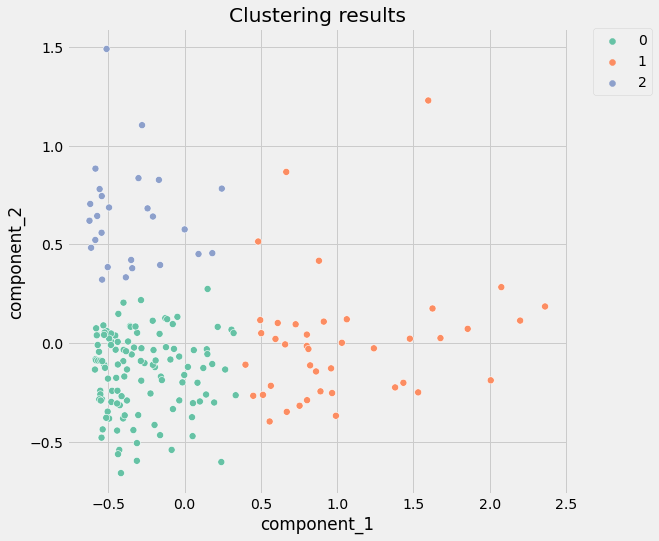

In [145]:
t = kmeans_pipline(dd,3)
pca_cluster_plot(t)

In [146]:
t

,component_1,component_2,predicted_cluster
0,-0.613717,0.482584,2
1,-0.395931,-0.169489,0
2,-0.401335,0.204480,0
3,-0.455124,0.038031,0
4,0.966465,-0.253219,1
...,...,...,...
183,0.150183,0.273822,0
184,-0.550201,-0.291103,0
185,-0.544977,0.558623,2
186,-0.161022,0.395231,2


In [157]:
dc = train_df.join(t)
t0 = dc[dc['predicted_cluster'] == 0]
t1 = dc[dc['predicted_cluster'] == 1]
t2 = dc[dc['predicted_cluster'] == 2]

In [159]:
t2.describe()

,#AUTHID,NETWORKSIZE,BETWEENNESS,NBETWEENNESS,DENSITY,BROKERAGE,NBROKERAGE,TRANSITIVITY,post_count,total_words,...,surprise,trust,cEXT,cNEU,cAGR,cCON,cOPN,component_1,component_2,predicted_cluster
count,27.000000,27.000000,27.000000,27.000000,27.000000,27.000000,27.000000,27.000000,27.000000,27.000000,...,27.000000,27.000000,27.000000,27.000000,27.000000,27.000000,27.000000,27.000000,27.000000,27.0
mean,139.592593,160.333333,13150.671852,83.180370,0.079630,15183.333333,0.468148,0.330370,23.592593,297.814815,...,4.370370,7.888889,0.074074,0.444444,0.296296,0.481481,0.777778,-0.365110,0.641418,2.0
std,81.860697,84.377358,12681.285764,8.058409,0.027802,15428.069357,0.011448,0.089935,24.994244,302.144010,...,4.683425,9.044052,0.266880,0.506370,0.465322,0.509175,0.423659,0.258159,0.254520,0.0
min,2.000000,56.000000,1054.670000,61.250000,0.040000,1362.000000,0.430000,0.120000,1.000000,10.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.624318,0.321205,2.0
25%,77.000000,88.000000,3331.610000,81.125000,0.060000,3504.500000,0.460000,0.280000,5.000000,46.500000,...,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,1.000000,-0.565694,0.452994,2.0
50%,132.000000,144.000000,8951.170000,84.170000,0.070000,9577.000000,0.470000,0.330000,18.000000,230.000000,...,3.000000,4.000000,0.000000,0.000000,0.000000,0.000000,1.000000,-0.496025,0.620622,2.0
75%,214.000000,219.500000,20293.200000,88.215000,0.095000,22574.500000,0.480000,0.380000,30.000000,495.000000,...,6.000000,11.000000,0.000000,1.000000,1.000000,1.000000,1.000000,-0.225923,0.761981,2.0
max,250.000000,367.000000,46193.600000,92.650000,0.150000,62940.000000,0.480000,0.520000,99.000000,1222.000000,...,15.000000,37.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.243193,1.489297,2.0


In [148]:
dc.describe()

,#AUTHID,NETWORKSIZE,NBETWEENNESS,DENSITY,NBROKERAGE,TRANSITIVITY,post_count,total_words,avg_words,me_perpost,...,fear,joy,negative,positive,sadness,surprise,trust,component_1,component_2,predicted_cluster
count,188.000000,188.000000,188.000000,188.000000,188.000000,188.000000,188.000000,188.000000,188.000000,188.000000,...,188.000000,188.000000,188.000000,188.000000,188.00000,188.000000,188.000000,1.880000e+02,1.880000e+02,188.000000
mean,125.643617,426.819149,94.291809,0.031330,0.489468,0.131809,43.196809,642.372340,14.599741,0.696486,...,11.207447,20.909574,21.585106,35.031915,11.12234,10.329787,18.867021,-5.905442e-18,-1.181088e-17,0.510638
std,71.171974,325.190490,6.086079,0.027824,0.011734,0.108568,45.469019,721.637776,7.077058,0.610175,...,14.381530,23.902595,25.549118,40.948762,12.94955,12.523252,22.966341,6.514815e-01,3.588834e-01,0.734842
min,2.000000,29.000000,61.250000,0.000000,0.430000,0.000000,1.000000,6.000000,2.666667,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,-6.243181e-01,-6.586104e-01,0.000000
25%,66.750000,187.750000,93.467500,0.010000,0.490000,0.057500,9.000000,109.500000,9.964286,0.298529,...,1.000000,4.000000,3.750000,6.000000,2.00000,2.000000,3.000000,-4.815643e-01,-2.459855e-01,0.000000
50%,125.500000,323.500000,96.215000,0.020000,0.490000,0.100000,27.000000,357.500000,12.948684,0.546383,...,5.000000,13.000000,11.000000,19.500000,7.00000,5.000000,10.000000,-2.535124e-01,-5.010656e-02,0.000000
75%,186.250000,563.500000,97.950000,0.040000,0.500000,0.172500,65.750000,918.500000,18.173718,0.903333,...,15.000000,28.250000,30.500000,54.000000,15.00000,14.250000,28.250000,2.408717e-01,9.736218e-02,1.000000
max,250.000000,1596.000000,99.670000,0.150000,0.500000,0.520000,223.000000,3572.000000,46.000000,4.750000,...,77.000000,123.000000,119.000000,218.000000,64.00000,76.000000,154.000000,2.362639e+00,1.489297e+00,2.000000
